In [ ]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

## Slope

In [2]:
def get_terrain_data(min_lat, max_lat, min_lon, max_lon, resolution=30) -> pd.DataFrame:
    """
    Get terrain slope and aspect data for a coordinate range
    
    Parameters:
    min_lat, max_lat: Latitude bounds
    min_lon, max_lon: Longitude bounds
    resolution: Resolution in meters
    
    Returns:
    pandas.DataFrame: DataFrame with latitude, longitude, slope, aspect columns
    """
    print(f"Fetching elevation data for: ({min_lat:.4f}, {min_lon:.4f}) to ({max_lat:.4f}, {max_lon:.4f})")
    
    # Calculate number of samples based on resolution
    lat_samples = int((max_lat - min_lat) * 111000 / resolution) + 1
    lon_samples = int((max_lon - min_lon) * 111000 / resolution) + 1
    
    # Create latitude and longitude arrays
    lats = np.linspace(min_lat, max_lat, lat_samples)
    lons = np.linspace(min_lon, max_lon, lon_samples)
    
    # Create coordinate grid
    lat_grid, lon_grid = np.meshgrid(lats, lons)
    
    # Prepare points for API request
    points = []
    for i in range(lat_grid.shape[0]):
        for j in range(lat_grid.shape[1]):
            points.append({
                "latitude": lat_grid[i, j],
                "longitude": lon_grid[i, j]
            })
    
    # API request to get elevation data
    url = "https://api.open-elevation.com/api/v1/lookup"
    payload = {"locations": points}
    
    try:
        response = requests.post(url, json=payload)
        data = response.json()
    except Exception as e:
        print(response.status_code)
        print(e)
        raise Exception(e)
    
    # Extract elevations and reshape to grid
    elevations = np.array([point["elevation"] for point in data["results"]])
    elevation_grid = elevations.reshape(lat_grid.shape)
    
    print(f"Successfully fetched elevation data: {lat_samples}x{lon_samples} grid")
 

    # Calculate slope and aspect
    # Get approximate cell size in meters
    cell_size_y = (max_lat - min_lat) / (lat_samples-1) * 111000  # m/cell
    cell_size_x = (max_lon - min_lon) / (lon_samples-1) * 111000 * np.cos(np.radians(np.mean([min_lat, max_lat])))  # m/cell
    
    # Calculate slope (in degrees)
    dy, dx = np.gradient(elevation_grid, cell_size_y, cell_size_x)
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
    
    # Calculate aspect (in degrees)
    aspect = np.degrees(np.arctan2(dy, dx))
    aspect = np.mod(aspect + 360, 360)
    
    # Create DataFrame
    # Flatten the arrays
    lat_flat = lat_grid.flatten()
    lon_flat = lon_grid.flatten()
    slope_flat = slope.flatten()
    aspect_flat = aspect.flatten()
    
    # Create a DataFrame with just the requested columns
    df = pd.DataFrame({
        'latitude': lat_flat,
        'longitude': lon_flat,
        'slope': slope_flat,        # in degrees (0-90)
        'aspect': aspect_flat       # in degrees (0-360, clockwise from north)
    })
    
    print(f"Created DataFrame with {len(df)} points")
    return df

## Solar irradiance

In [ ]:
irradiance_df = pd.read_csv('irradiance_data_res4.0.csv')

## Compute the values

In [6]:
min_lat, max_lat = -20, -19
min_lon, max_lon = -51, -50 

In [7]:
terrain_df = get_terrain_data(
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    resolution=10000
)

Fetching elevation data for: (-20.0000, -51.0000) to (-19.0000, -50.0000)
Successfully fetched elevation data: 12x12 grid
Created DataFrame with 144 points


In [8]:
def get_interpolated_irradiance_df(irradiance_df: pd.DataFrame, terrain_df: pd.DataFrame) -> pd.DataFrame:
    # Extract source points and values from irradiance_df
    points = irradiance_df[['latitude', 'longitude']].values
    values = irradiance_df['irradiance'].values

    # Get target points from your other DataFrame
    target_points = terrain_df[['latitude', 'longitude']].values

    interpolated_values = griddata(points, values, target_points, method='cubic')

    # Check for NaN values in the interpolated data
    nan_mask = np.isnan(interpolated_values)
    if np.any(nan_mask):
        print(f"Found {np.sum(nan_mask)} NaN values in interpolated data.")
        interpolated_nn = griddata(points, values, target_points, method='nearest')
        interpolated_values[nan_mask] = interpolated_nn[nan_mask]
        print("Replaced NaN values with nearest neighbor interpolation")

    # Create a new DataFrame to store the results
    interpolated_df = pd.DataFrame({
        'latitude': terrain_df['latitude'],
        'longitude': terrain_df['longitude'],
        'interpolated_irradiance': interpolated_values
    })
    return interpolated_df

In [9]:
terrain_df.head()

,latitude,longitude,slope,aspect
0,-20.000000,-51.0,0.000000,0.000000
1,-19.909091,-51.0,0.436608,77.247957
2,-19.818182,-51.0,0.198356,34.924785
3,-19.727273,-51.0,0.190791,120.340261
4,-19.636364,-51.0,0.393171,85.166544


In [10]:
irradiance_df = pd.read_csv("irradiance_data_res4.0.csv")

Interpolate solar irradiance

In [11]:
import numpy as np
from scipy.interpolate import griddata

In [12]:
irradiance_df.head()

,latitude,longitude,irradiance
0,-60.0,-90.0,2.247385
1,-60.0,-86.0,2.229692
2,-60.0,-82.0,2.256769
3,-60.0,-78.0,2.294077
4,-60.0,-74.0,2.290462


In [13]:
interpolated_df = get_interpolated_irradiance_df(irradiance_df, terrain_df)

In [14]:
interpolated_df.describe()

,latitude,longitude,interpolated_irradiance
count,144.000000,144.000000,144.000000
mean,-19.500000,-50.500000,5.531610
std,0.314918,0.314918,0.019431
min,-20.000000,-51.000000,5.491288
25%,-19.750000,-50.750000,5.516263
50%,-19.500000,-50.500000,5.532905
75%,-19.250000,-50.250000,5.547180
max,-19.000000,-50.000000,5.568022


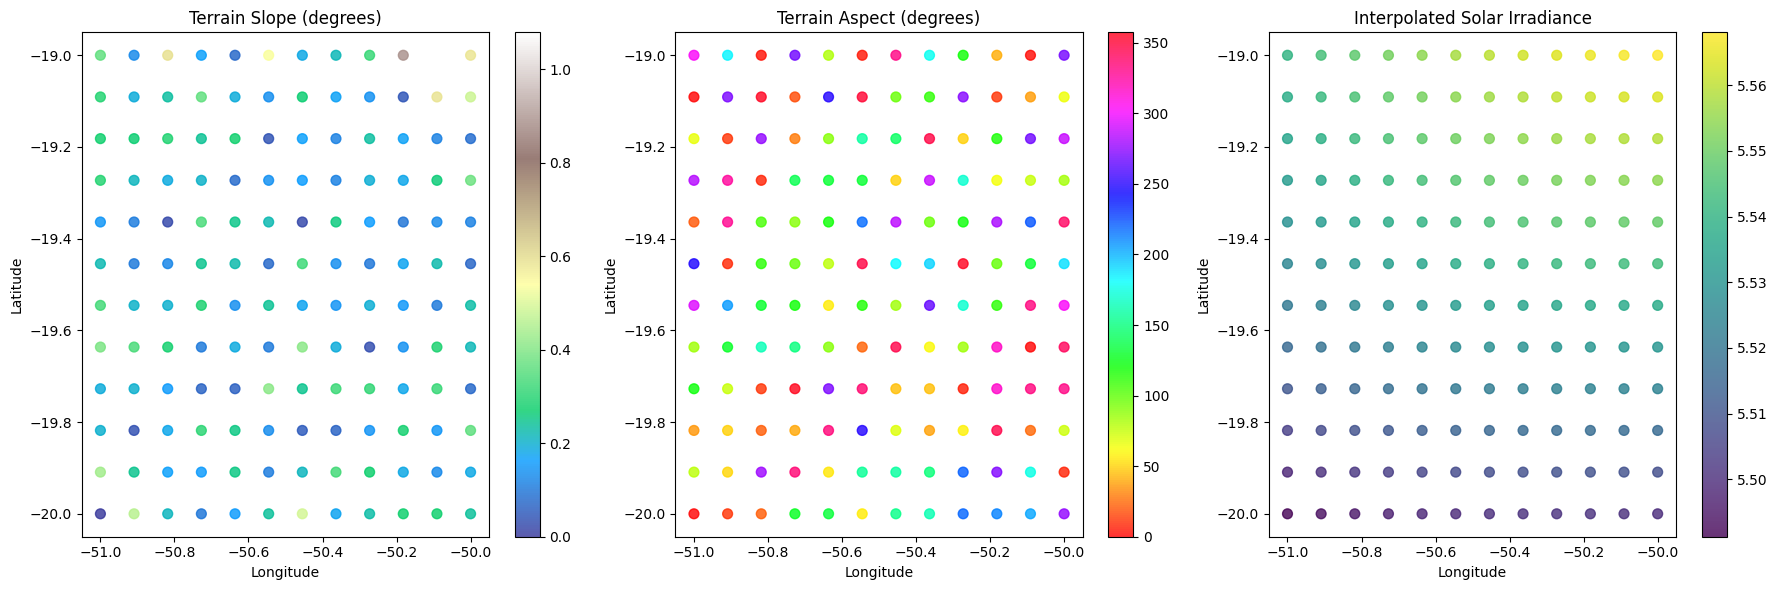

In [15]:
# Merge terrain data with interpolated irradiance
combined_df = pd.merge(
    terrain_df, 
    interpolated_df[['latitude', 'longitude', 'interpolated_irradiance']], 
    on=['latitude', 'longitude']
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Slope
slope_plot = axes[0].scatter(
    combined_df['longitude'], 
    combined_df['latitude'],
    c=combined_df['slope'], 
    cmap='terrain',
    s=50,
    alpha=0.8
)
axes[0].set_title('Terrain Slope (degrees)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(slope_plot, ax=axes[0])

# Plot 2: Aspect
aspect_plot = axes[1].scatter(
    combined_df['longitude'], 
    combined_df['latitude'],
    c=combined_df['aspect'], 
    cmap='hsv',
    s=50,
    alpha=0.8
)
axes[1].set_title('Terrain Aspect (degrees)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(aspect_plot, ax=axes[1])

# Plot 3: Interpolated Irradiance
irradiance_plot = axes[2].scatter(
    combined_df['longitude'], 
    combined_df['latitude'],
    c=combined_df['interpolated_irradiance'], 
    cmap='viridis',
    s=50,
    alpha=0.8
)
axes[2].set_title('Interpolated Solar Irradiance')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
fig.colorbar(irradiance_plot, ax=axes[2])

plt.tight_layout()
plt.show()